## Figure: bibiplots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from plot_utils import adjustlabels
import seaborn as sns
import os
import imageio

import sys
sys.path.append('../code')
import sparseRRR

In [3]:
def preprocess(data, slice_idx, loc_features_idx):
    X = data['Firing rate']
    X = X[slice_idx,:] # select the time slice
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X = X - X_mean
    X = X / X_std

    Y = data['Locomotion']
    Y = Y[slice_idx,:] # select the time slice
    Y = Y[:,loc_features_idx] # select the locomotion features
    Y_mean = np.mean(Y, axis=0)
    Y_std = np.std(Y, axis=0)
    Y = Y - Y_mean
    Y = Y / Y_std
    
    return X,Y, X_mean, X_std, Y_mean, Y_std 

In [4]:
data = pickle.load(open('../data/purkinje_extended_full.pickle', 'rb'))
locomotion_names = data['locomotion_names']
cell_names = data['cell_names']

Not all timepoints, not all locomotion features:

In [24]:
slice = np.linspace(0, 500000, 500000, dtype=int)
selected_features = [5,6,7,8,9,10,11,12,-8,-7,-6,-5,-4,-3,-2,-1] # locomotion features to use
np.array(locomotion_names)[selected_features]

array(['X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR',
       'X-s FL', 'X-s HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL',
       'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL'], dtype='<U11')

In [ ]:
X_tr,Y_tr, X_tr_mean, X_tr_std, Y_tr_mean, Y_tr_std = preprocess(data, slice, selected_features)
print('Shape of X:', X_tr.shape, '\nShape of Y:', Y_tr.shape)
w,v = sparseRRR.relaxed_elastic_rrr(X_tr, Y_tr, rank=2, alpha=.67, l1_ratio=1)
print('{} neurons selected:'.format(np.sum(w[:,0]!=0)))
print(cell_names[w[:,0]!=0])

Shape of X: (500000, 105) 
Shape of Y: (500000, 16)


### Movie

In [21]:
Y_test = data['Locomotion'][500000:5010000,:]
Y_test = Y_test[:,selected_features]
X_test = data['Firing rate'][500000:5010000,:]
X_test = X_test - X_tr_mean
X_test = X_test / X_tr_std
Y_test = Y_test - Y_tr_mean
Y_test = Y_test / Y_tr_std
Zx = X_test @ w
Zy = Y_test @ v

In [22]:
slice = np.linspace(0, 10000, 10000, dtype=int)
xylim=3.9
scaleFactor=3.5
s=2
time_samples=slice[::10][:5]
#L = np.corrcoef(np.concatenate((Zy[:,:2], Y_test), axis=1), rowvar=False)[2:,:2]

KeyboardInterrupt: 

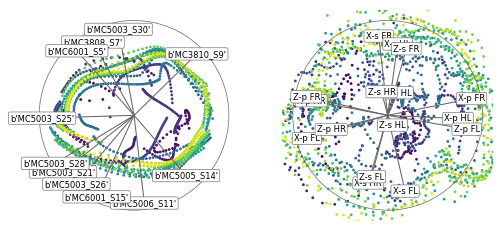

In [23]:
for i, tp in enumerate(slice[::100][1:]):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    ax1 = axes[0]
    ax2 = axes[1]
    
    # Plotting on ax1
    ax1.scatter(Zx[0:tp, 0], Zx[0:tp, 1], c=range(tp), cmap='viridis', s=1)
    labels = []
    L = np.corrcoef(np.concatenate((Zx[:, :2], X_test), axis=1), rowvar=False)[2:, :2]
    for j in np.where(w[:, 0] != 0)[0]:
        ax1.plot([0, scaleFactor * L[j, 0]], [0, scaleFactor * L[j, 1]], linewidth=.75, color=[.4, .4, .4], zorder=1)
        t = ax1.text(scaleFactor * L[j, 0], scaleFactor * L[j, 1], data['cell_names'][j], 
                     ha='center', va='center', color='k', fontsize=6,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
        labels.append(t)
    adjustlabels(fig, ax1, labels)
    circ = plt.Circle((0, 0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    ax1.add_patch(circ)
    
    # Plotting on ax2
    ax2.scatter(Zy[0:tp, 0], Zy[0:tp, 1], c=range(tp), cmap='viridis', s=1)
    labels = []
    L = np.corrcoef(np.concatenate((Zy[:, :2], Y_test), axis=1), rowvar=False)[2:, :2]
    for j in range(Y_test.shape[1]):
        ax2.plot([0, scaleFactor * L[j, 0]], [0, scaleFactor * L[j, 1]], linewidth=.75, color=[.4, .4, .4], zorder=1)
        t = ax2.text(scaleFactor * L[j, 0], scaleFactor * L[j, 1], np.array(data['locomotion_names'])[selected_features][j], 
                     ha='center', va='center', color='k', fontsize=6,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
        labels.append(t)
    adjustlabels(fig, ax2, labels)
    circ = plt.Circle((0, 0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5)
    ax2.add_patch(circ)

    # Setting limits and aspect ratio
    for ax in axes:
        ax.set_xlim([-xylim, xylim])
        ax.set_ylim([-xylim, xylim])
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([])
        ax.set_yticks([])
    
    sns.despine(left=True, bottom=True)
    
    # Save and close the figure
    plt.savefig(f'./movie_ext/bibiplot{i}.png')
    plt.close(fig)

In [19]:
# Directory where images are saved
image_dir = './movie_ext/'

# List of image filenames
images = []
for i in range(len(slice[::100][1:])):
    filename = f'bibiplot{i}.png'
    images.append(imageio.imread(os.path.join(image_dir, filename)))

# Save as GIF
output_file = 'bibiplot_animation_ext.gif'
imageio.mimsave(output_file, images, duration=0.5)  # Adjust duration as needed

/var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_1841/1558028202.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(image_dir, filename)))
